1. นาย วิทยา พิมพ์ตา 6310401157
2. นายศุภกิจ ชาวประเสริฐ 6310404059
3. นายกฤษดา เครือเสนา 6310406256
4. นายเกริกวิทย์ ศุภวรรธนะกุล 6310400916


## pull data

In [ ]:
import tweepy 
import re
import csv

#Keys and Access Tokens
consumer_key  = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)


csvFile = open('new-file', 'a')
csvWriter = csv.writer(csvFile)

search_words = "Covid19 or Coronavirus"      #enter your words
new_search = search_words + " -filter:retweets"

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

for tweet in tweepy.Cursor(api.search,q=new_search,
                           lang="en",
                           since_id=0).items():
    raw_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet.text).split())
    print(tweet.created_at,remove_emoji(raw_tweet))
    csvWriter.writerow([tweet.created_at, remove_emoji(raw_tweet)])

## sentiment data

In [ ]:
#Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import word cleaning libraries
import nltk
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from  nltk.stem import SnowballStemmer
import string

#Import learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pickle
import gensim

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 5
W2V_EPOCH = 32
W2V_MIN_COUNT = 5

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"

In [ ]:
covid_df = pd.read_csv('/content/Covid-19-AI_1.csv')
covid_df=covid_df.dropna().reset_index(drop=True)
covid_df=covid_df.drop(["time"],axis=1)
covid_df.head(10)

,comment
0,Why not mention that if a Poilievre HQ gov...
1,He was indicted for an alleged scheme to defr...
2,If you ve been forced to lose your job in th...
3,Proof that is captured controlled by the ph...
4,Today we amended the emergency use authoriza...
5,Kids were not isolated for 2 years Schools i...
6,A new analysis by Senate Democrats of how the...
7,1vy McKernan nineties
8,If you ve been forced to lose your job in th...
9,Pfizer boss refuses to testify to EU Parliame...


In [ ]:
nltk.download('punkt')

nltk.download('stopwords')
stops = set(stopwords.words('english'))
def clearStopwords(sentence):
    words = word_tokenize(sentence)

    wordsFiltered = []

    for w in words:
        if w not in stops:
            wordsFiltered.append(w)

    return ' '.join(wordsFiltered)
#Delete stopwords
covid_df['review_clear'] = covid_df['comment'].map(lambda x: clearStopwords(x))

#Delete punctuation
covid_df['review_punctuation'] = covid_df.apply(lambda row:(row['review_clear']).translate(str.maketrans('', '', string.punctuation)), axis=1)
covid_df['review_punctuation'] = covid_df['review_punctuation'].str.lower()
covid_df['review_punctuation'] = covid_df.apply(lambda row:' '.join((row['review_punctuation']).split()), axis=1)
translation_table = str.maketrans('', '', string.digits)
covid_df['review_punctuation'] = covid_df['review_punctuation'].str.translate(translation_table)

#Delete stopwords (round 2)
covid_df['review_punctuation'] = covid_df['review_punctuation'].map(lambda x: clearStopwords(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
covid_df.head(10)

,comment,review_clear,review_punctuation
0,Why not mention that if a Poilievre HQ gov...,Why mention Poilievre HQ government power COVI...,mention poilievre hq government power covid so...
1,He was indicted for an alleged scheme to defr...,He indicted alleged scheme defraud Small Busin...,indicted alleged scheme defraud small business...
2,If you ve been forced to lose your job in th...,If forced lose job military anywhere else refu...,forced lose job military anywhere else refusin...
3,Proof that is captured controlled by the ph...,Proof captured controlled pharmaceutical indus...,proof captured controlled pharmaceutical indus...
4,Today we amended the emergency use authoriza...,Today amended emergency use authorizations EUA...,today amended emergency use authorizations eua...
5,Kids were not isolated for 2 years Schools i...,Kids isolated 2 years Schools Canada closed 9 ...,kids isolated years schools canada closed week...
6,A new analysis by Senate Democrats of how the...,A new analysis Senate Democrats U S government...,new analysis senate democrats u government bun...
7,1vy McKernan nineties,1vy McKernan nineties,vy mckernan nineties
8,If you ve been forced to lose your job in th...,If forced lose job military anywhere else refu...,forced lose job military anywhere else refusin...
9,Pfizer boss refuses to testify to EU Parliame...,Pfizer boss refuses testify EU Parliament COVI...,pfizer boss refuses testify eu parliament covi...


In [ ]:
nltk.download('omw-1.4')

def lemmaWords(words):
    lst = []
    lemmatiser = WordNetLemmatizer()
    for word in words:
        lst.append(lemmatiser.lemmatize(word, pos='v'))
    return lst

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(covid_df['review_punctuation'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyzer.polarity_scores(covid_df['review_punctuation'][i])["compound"]
    pos = analyzer.polarity_scores(covid_df['review_punctuation'][i])["pos"]
    neu = analyzer.polarity_scores(covid_df['review_punctuation'][i])["neu"]
    neg = analyzer.polarity_scores(covid_df['review_punctuation'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })
    
sentiments_score = pd.DataFrame.from_dict(scores)
covid_df = covid_df.join(sentiments_score)
covid_df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,comment,review_clear,review_punctuation,Compound,Positive,Negative,Neutral
0,Why not mention that if a Poilievre HQ gov...,Why mention Poilievre HQ government power COVI...,mention poilievre hq government power covid so...,-0.6908,0.0,0.402,0.598
1,He was indicted for an alleged scheme to defr...,He indicted alleged scheme defraud Small Busin...,indicted alleged scheme defraud small business...,0.0000,0.0,0.000,1.000
2,If you ve been forced to lose your job in th...,If forced lose job military anywhere else refu...,forced lose job military anywhere else refusin...,-0.8126,0.0,0.512,0.488
3,Proof that is captured controlled by the ph...,Proof captured controlled pharmaceutical indus...,proof captured controlled pharmaceutical indus...,0.0000,0.0,0.000,1.000
4,Today we amended the emergency use authoriza...,Today amended emergency use authorizations EUA...,today amended emergency use authorizations eua...,-0.3818,0.0,0.178,0.822


In [ ]:
covid_df=covid_df.drop(["comment"],axis=1)
covid_df=covid_df.drop(["review_clear"],axis=1)
covid_df

,review_punctuation,Compound,Positive,Negative,Neutral
0,mention poilievre hq government power covid so...,-0.6908,0.000,0.402,0.598
1,indicted alleged scheme defraud small business...,0.0000,0.000,0.000,1.000
2,forced lose job military anywhere else refusin...,-0.8126,0.000,0.512,0.488
3,proof captured controlled pharmaceutical indus...,0.0000,0.000,0.000,1.000
4,today amended emergency use authorizations eua...,-0.3818,0.000,0.178,0.822
...,...,...,...,...,...
2537,los angeles take extra second put mask got cor...,0.4404,0.225,0.000,0.775
2538,unicefmoldova social listening reports help bu...,0.5106,0.314,0.098,0.588
2539,groups still threatened covid pregnant women s...,-0.7096,0.000,0.463,0.537
2540,children young months eligible covid booster s...,0.0000,0.000,0.000,1.000


In [ ]:
covid_df.head(100)

,review_punctuation,Compound,Positive,Negative,Neutral
0,mention poilievre hq government power covid so...,-0.6908,0.000,0.402,0.598
1,indicted alleged scheme defraud small business...,0.0000,0.000,0.000,1.000
2,forced lose job military anywhere else refusin...,-0.8126,0.000,0.512,0.488
3,proof captured controlled pharmaceutical indus...,0.0000,0.000,0.000,1.000
4,today amended emergency use authorizations eua...,-0.3818,0.000,0.178,0.822
...,...,...,...,...,...
95,democrats kicked soldiers sailors airmen milit...,-0.3182,0.000,0.187,0.813
96,feeling sick could covid flu cold stay home ta...,-0.6597,0.077,0.304,0.619
97,know right people look funny say protection bs...,0.4404,0.244,0.000,0.756
98,borisjohnson comedy coronacrisis coronavirus f...,0.6597,0.435,0.000,0.565


In [ ]:
covid_df.dtypes
covid_df["sentiment"] = "sentiment"
covid_df["sentiment"].loc[covid_df["Positive"] > covid_df["Negative"]] = "Positive"
covid_df["sentiment"].loc[covid_df["Negative"] > covid_df["Positive"]] = "Negative"
covid_df["sentiment"].loc[covid_df["Neutral"] == 1.000 ] = "Neutral"

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
covid_df.pivot_table(columns=["sentiment"],aggfunc="size")

sentiment
Negative     1031
Neutral       677
Positive      828
sentiment       6
dtype: int64

In [ ]:
covid_df.head(10)
covid_df=covid_df.drop(["Compound"],axis=1)
covid_df=covid_df.drop(["Positive"],axis=1)
covid_df=covid_df.drop(["Negative"],axis=1)
covid_df=covid_df.drop(["Neutral"],axis=1)

In [ ]:
covid_df

,review_punctuation,sentiment
0,mention poilievre hq government power covid so...,Negative
1,indicted alleged scheme defraud small business...,Neutral
2,forced lose job military anywhere else refusin...,Negative
3,proof captured controlled pharmaceutical indus...,Neutral
4,today amended emergency use authorizations eua...,Negative
...,...,...
2537,los angeles take extra second put mask got cor...,Positive
2538,unicefmoldova social listening reports help bu...,Positive
2539,groups still threatened covid pregnant women s...,Negative
2540,children young months eligible covid booster s...,Neutral


In [ ]:
df_train, df_test = train_test_split(covid_df, test_size=1-0.7,random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1779
TEST size: 763


In [ ]:
df_train

,review_punctuation,sentiment
839,since start pandemic americans died covid deat...,Negative
1427,happen oh receipts weed hookers donuts,Neutral
2411,cerb new program rolled weeks covid workforce ...,Negative
2405,nice streak lasted nearly yrs dodging covid fi...,Positive
1196,chinese cities continuing optimize response co...,Positive
...,...,...
1638,planned parenthood affiliates accused improper...,Negative
1095,week article konstanty cieslinski explained pa...,Positive
1130,free shutterstock giving free stock images sma...,Positive
1294,mers coronavirus recent years fatality question,Negative


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(df_train)

In [ ]:
covid_df['review_token'] = covid_df.apply(lambda row: nltk.word_tokenize(row['review_punctuation']), axis=1)
covid_df['review_token'] = covid_df['review_token'].map(lambda x: lemmaWords(x))
covid_df=covid_df.drop(["review_punctuation"],axis=1)

In [ ]:
covid_df.head(10)

,sentiment,review_token
0,Negative,"[mention, poilievre, hq, government, power, co..."
1,Neutral,"[indict, allege, scheme, defraud, small, busin..."
2,Negative,"[force, lose, job, military, anywhere, else, r..."
3,Neutral,"[proof, capture, control, pharmaceutical, indu..."
4,Negative,"[today, amend, emergency, use, authorizations,..."
5,Negative,"[kid, isolate, years, school, canada, close, w..."
6,Neutral,"[new, analysis, senate, democrats, u, governme..."
7,Neutral,"[vy, mckernan, nineties]"
8,Negative,"[force, lose, job, military, anywhere, else, r..."
9,Neutral,"[pfizer, boss, refuse, testify, eu, parliament..."


In [ ]:
numpy_df = covid_df.to_numpy()
numpy_df

array([['Negative',
        list(['mention', 'poilievre', 'hq', 'government', 'power', 'covid', 'social', 'murder'])],
       ['Neutral',
        list(['indict', 'allege', 'scheme', 'defraud', 'small', 'business', 'association', 'obtain', 'coronavirus', 'relate', 'business'])],
       ['Negative',
        list(['force', 'lose', 'job', 'military', 'anywhere', 'else', 'refuse', 'covid', 'vaccination', 'reply', 'twe'])],
       ...,
       ['Negative',
        list(['group', 'still', 'threaten', 'covid', 'pregnant', 'women', 'seem', 'unaware', 'risk', 'include', 'miscarriage'])],
       ['Neutral',
        list(['children', 'young', 'months', 'eligible', 'covid', 'booster', 'shots'])],
       ['Negative',
        list(['group', 'still', 'threaten', 'covid', 'pregnant', 'women', 'seem', 'unaware', 'risk', 'include', 'miscarriage'])]],
      dtype=object)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(numpy_df[:,1])

In [ ]:
len(tokenizer.index_word)

3941

In [ ]:
df_train, df_test = train_test_split(covid_df, test_size=1-0.7,random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1779
TEST size: 763


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
df_train



,sentiment,review_token
839,Negative,"[since, start, pandemic, americans, die, covid..."
1427,Neutral,"[happen, oh, receipt, weed, hookers, donuts]"
2411,Negative,"[cerb, new, program, roll, weeks, covid, workf..."
2405,Positive,"[nice, streak, last, nearly, yrs, dodge, covid..."
1196,Positive,"[chinese, cities, continue, optimize, response..."
...,...,...
1638,Negative,"[plan, parenthood, affiliate, accuse, improper..."
1095,Positive,"[week, article, konstanty, cieslinski, explain..."
1130,Positive,"[free, shutterstock, give, free, stock, image,..."
1294,Negative,"[mers, coronavirus, recent, years, fatality, q..."


In [ ]:
w2v_model.build_vocab(df_train)

In [ ]:
w2v_model.most_

In [ ]:
# DataFrame
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
import tensorflow_hub as hub
from keras.utils import to_categorical
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/covidWithSentiment.csv')
df = df.drop(['Unnamed: 0','Compound','Positive','Negative','Neutral'],axis=1)
df = df[df.sentiment != 'sentiment']
df

,review_punctuation,sentiment
0,mention poilievre hq government power covid so...,Negative
1,indicted alleged scheme defraud small business...,Neutral
2,forced lose job military anywhere else refusin...,Negative
3,proof captured controlled pharmaceutical indus...,Neutral
4,today amended emergency use authorizations eua...,Negative
...,...,...
2537,los angeles take extra second put mask got cor...,Positive
2538,unicefmoldova social listening reports help bu...,Positive
2539,groups still threatened covid pregnant women s...,Negative
2540,children young months eligible covid booster s...,Neutral


## word2vec

In [ ]:
df["sentiment"].loc[(df["sentiment"] == "Neutral")] = 0
df["sentiment"].loc[(df["sentiment"] == "Positive")] = 1
df["sentiment"].loc[(df["sentiment"] == "Negative")] = -1

In [ ]:
data = df.to_numpy()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data[:,0])

In [ ]:
tokenizer.index_word

{1: 'covid',
 2: 'coronavirus',
 3: 'vaccine',
 4: 'amp',
 5: 'new',
 6: 'military',
 7: 'people',
 8: 'florida',
 9: 'st',
 10: 'deaths',
 11: 'receiving',
 12: 'funds',
 13: 'accused',
 14: 'kids',
 15: 'republican',
 16: 'vaccination',
 17: 'planned',
 18: 'parenthood',
 19: 'affiliates',
 20: 'improperly',
 21: 'stimulus',
 22: 'job',
 23: 'today',
 24: 'pandemic',
 25: 'fda',
 26: 'cases',
 27: 'ba',
 28: 'else',
 29: 'children',
 30: 'lose',
 31: 'forced',
 32: 'anywhere',
 33: 'refusing',
 34: 'reply',
 35: 'twe',
 36: 'still',
 37: 'masks',
 38: 'updated',
 39: 'one',
 40: 'get',
 41: 'use',
 42: 'bivalent',
 43: 'says',
 44: 'take',
 45: 'health',
 46: 'flu',
 47: 'emergency',
 48: 'vaccines',
 49: 'democrats',
 50: 'time',
 51: 'moderna',
 52: 'pfizer',
 53: 'bringbackmasks',
 54: 'said',
 55: 'soldiers',
 56: 'omicron',
 57: 'also',
 58: 'patients',
 59: 'since',
 60: 'stop',
 61: 'years',
 62: 'work',
 63: 'dr',
 64: 'th',
 65: 'months',
 66: 'w',
 67: 'back',
 68: 'us',
 6

In [ ]:
#one-hot
print("Unique lables = " , set(data[:,1]))
y=to_categorical([ int(i) for i in data[:,1]])
print(y)

Unique lables =  {0, 1, -1}
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
#padding data with 0
tts = tokenizer.texts_to_sequences(data[:,0])
print("Raw Texts to Sequence:")
for s in tts: print(s)
maxlen = max([len(s) for s in tts])
print("max sentense's length = " , maxlen)
x = pad_sequences(tts, maxlen=maxlen, padding="post")
print("Squence Padding at maxlen words, post padding:\n", x)

Raw Texts to Sequence:
[2383, 2384, 2385, 214, 1294, 1, 895, 2386]
[1295, 1296, 370, 311, 312, 515, 1297, 1629, 2, 630, 515]
[31, 30, 22, 6, 32, 28, 33, 1, 16, 34, 35]
[1061, 2387, 1630, 2388, 896, 1631, 65, 2389, 324]
[23, 118, 47, 41, 124, 125, 38, 42, 51, 52, 119, 1, 126]
[14, 1632, 61, 473, 371, 631, 215, 1633]
[5, 779, 277, 49, 80, 214, 1634, 325, 164, 24, 1635, 780]
[2390, 2391, 2392]
[31, 30, 22, 6, 32, 28, 33, 1, 16, 34, 35]
[52, 1298, 1062, 1299, 781, 1300, 1, 632]
[1636, 473, 2393, 1637, 2394, 1301, 1, 1302]
[184, 205, 372, 8, 144, 398, 399, 400, 343, 344, 2, 429]
[63, 782, 43, 39, 109, 699, 401, 700, 701, 145, 70, 185, 783]
[1638, 1303, 113, 2395, 216, 45, 1639, 1]
[2396, 2397, 58, 1, 630, 2398, 2399, 1063, 702, 571]
[1064, 1065, 897, 1066, 402, 1067, 132, 898, 297, 899, 784, 1068, 73, 64]
[345, 5, 278, 326, 215, 1, 346, 347, 242, 186, 348]
[2400, 1069, 403, 186, 785, 1, 313, 349]
[1640, 139, 900, 474, 165, 901, 252, 572, 2, 105, 26, 902]
[786, 5, 573, 1641, 1642, 1643, 1304

In [ ]:
#word embed
vocab_size = len(tokenizer.word_index) +1

np.random.seed(7)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=2,
                    input_length=maxlen))

model.compile(loss='categorical_crossentropy', optimizer='adam')
y_predict = model.predict(x)

print("y_predict shape:\n", y_predict.shape)
print(y_predict[0])
print(min(y_predict[0][0]))
model.summary()

80/80 [==============================] - 0s 1ms/step
y_predict shape:
 (2536, 19, 2)
[[ 0.03991212 -0.00331426]
 [-0.02586805  0.03915523]
 [-0.03398637  0.01254078]
 [-0.0462253   0.00279292]
 [-0.01938844  0.04554149]
 [-0.00963992  0.00162386]
 [ 0.03318271  0.01026297]
 [-0.00328487 -0.03652817]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]
 [-0.00503923  0.00500003]]
-0.0033142567
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 19, 2)             9086      
                                                                 
Total params: 9,086
Trainable params: 9,086
Non-trainable params: 0
________________________________

In [ ]:
combind_tts = tokenizer.texts_to_sequences(data[:,0])
maxlen = max([len(s) for s in combind_tts])
maxlen

19

In [ ]:
def get_tokenizer(tts, data):
    x = pad_sequences(tts, maxlen=maxlen, padding="post")
    y = to_categorical([ int(i) for i in data[:,1]])
    return x, y

In [ ]:
combind_x, combind_y = get_tokenizer(combind_tts, data)

## LSTM

In [ ]:
vocab_size = len(tokenizer.word_index) +1

# Fix Random Weight
# For reproducable
np.random.seed(10)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=10,
                    input_length=maxlen))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(combind_x,combind_y, batch_size=4000,epochs=100, validation_split=0.1,verbose=1)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 19, 10)            45430     
                                                                 
 dropout_5 (Dropout)         (None, 19, 10)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 32)               3456      
 onal)                                                           
                                                                 
 dense_28 (Dense)            (None, 3)                 99        
                                                                 
 dense_29 (Dense)            (None, 2)                 8         
                                                                 
Total params: 48,993
Trainable params: 48,993
Non-trainable params: 0
_________________________________________________

In [ ]:
score = model.evaluate(combind_x, combind_y, batch_size=24)

106/106 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.9858


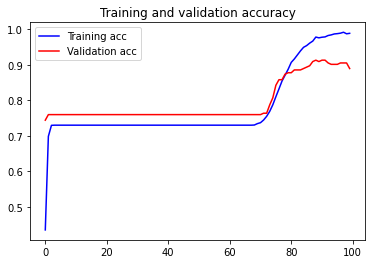

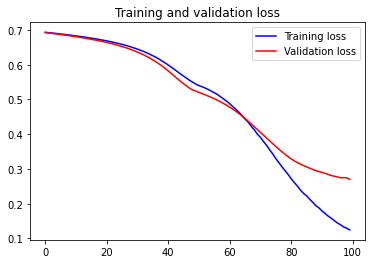

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## pretrained-word2vec-LSTM

In [ ]:
# DataFrame
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
import tensorflow_hub as hub


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/covidWithSentiment.csv')
df = df.drop(['Unnamed: 0','Compound','Positive','Negative','Neutral'],axis=1)
df = df[df.sentiment != 'sentiment']
df

,review_punctuation,sentiment
0,mention poilievre hq government power covid so...,Negative
1,indicted alleged scheme defraud small business...,Neutral
2,forced lose job military anywhere else refusin...,Negative
3,proof captured controlled pharmaceutical indus...,Neutral
4,today amended emergency use authorizations eua...,Negative
...,...,...
2537,los angeles take extra second put mask got cor...,Positive
2538,unicefmoldova social listening reports help bu...,Positive
2539,groups still threatened covid pregnant women s...,Negative
2540,children young months eligible covid booster s...,Neutral


In [ ]:
def get_max_length(df):
    max_length = 0
    for row in df['review_punctuation']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

def get_word2vec_enc(reviews):
    encoded_reviews = []
    for review_punctuation in reviews:
        tokens = review_punctuation.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews
        
def get_padded_encoded_reviews(encoded_reviews):
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 250))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def sentiment_encode(sentiment):
    if sentiment == 'Positive':
        return [1,0,0]
    elif sentiment  == 'Negative':
        return [0,1,0]
    else:
        return [0,0,1]
    
def preprocess(df):
    # encode words into word2vec
    reviews = df['review_punctuation'].tolist()
  
    encoded_reviews = get_word2vec_enc(reviews)
    padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews)
    # encoded sentiment
    sentiments = df['sentiment'].tolist()
    encoded_sentiment = [sentiment_encode(sentiment) for sentiment in sentiments]
    X = np.array(padded_encoded_reviews)
    Y = np.array(encoded_sentiment)
    return X, Y 

In [ ]:
#pretrained modle for W2V
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=10)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
max_length = get_max_length(df_train)
x_train, y_train = preprocess(df_train)
x_test, y_test= preprocess(df_test)

TRAIN size: 1775
TEST size: 761


In [ ]:
#Train
model = Sequential()
model.add(LSTM(120))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train,batch_size=4000,epochs=100, validation_split=0.1,verbose=1)

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 1.1025 - accuracy: 0.2974 - val_loss: 1.0956 - val_accuracy: 0.4382
Epoch 2/100
1/1 [==============================] - 1s 724ms/step - loss: 1.0930 - accuracy: 0.4164 - val_loss: 1.0892 - val_accuracy: 0.4101
Epoch 3/100
1/1 [==============================] - 1s 707ms/step - loss: 1.0865 - accuracy: 0.4602 - val_loss: 1.0834 - val_accuracy: 0.4045
Epoch 4/100
1/1 [==============================] - 1s 732ms/step - loss: 1.0788 - accuracy: 0.4678 - val_loss: 1.0772 - val_accuracy: 0.4101
Epoch 5/100
1/1 [==============================] - 1s 735ms/step - loss: 1.0708 - accuracy: 0.4534 - val_loss: 1.0702 - val_accuracy: 0.4045
Epoch 6/100
1/1 [==============================] - 1s 708ms/step - loss: 1.0632 - accuracy: 0.4389 - val_loss: 1.0622 - val_accuracy: 0.4045
Epoch 7/100
1/1 [==============================] - 1s 716ms/step - loss: 1.0540 - accuracy: 0.4408 - val_loss: 1.0530 - val_accuracy: 0.4101
Epoch 8/100
1/1 

In [ ]:
#TEST
score = model.evaluate(x_test, y_test, batch_size=24)

32/32 [==============================] - 1s 20ms/step - loss: 0.5958 - accuracy: 0.8160


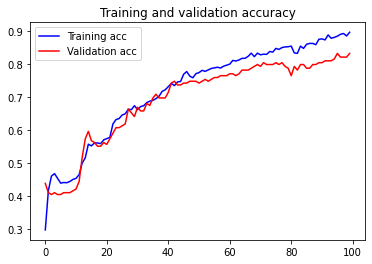

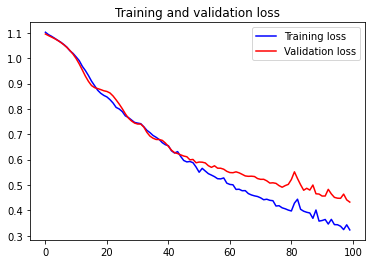

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Naive Bayes

In [ ]:
import pandas as pd
import numpy as np# Read the data from CSV files

In [ ]:
df = pd.read_csv('/content/covidWithSentiment.csv')
df = df.drop(['Unnamed: 0','Compound','Positive','Negative','Neutral'],axis=1)
df = df[df.sentiment != 'sentiment']
df

,review_punctuation,sentiment
0,mention poilievre hq government power covid so...,Negative
1,indicted alleged scheme defraud small business...,Neutral
2,forced lose job military anywhere else refusin...,Negative
3,proof captured controlled pharmaceutical indus...,Neutral
4,today amended emergency use authorizations eua...,Negative
...,...,...
2537,los angeles take extra second put mask got cor...,Positive
2538,unicefmoldova social listening reports help bu...,Positive
2539,groups still threatened covid pregnant women s...,Negative
2540,children young months eligible covid booster s...,Neutral


In [ ]:
df["sentiment"].loc[(df["sentiment"] == "Neutral")] = 0
df["sentiment"].loc[(df["sentiment"] == "Positive")] = 1
df["sentiment"].loc[(df["sentiment"] == "Negative")] = -1
df

,review_punctuation,sentiment
0,mention poilievre hq government power covid so...,-1
1,indicted alleged scheme defraud small business...,0
2,forced lose job military anywhere else refusin...,-1
3,proof captured controlled pharmaceutical indus...,0
4,today amended emergency use authorizations eua...,-1
...,...,...
2537,los angeles take extra second put mask got cor...,1
2538,unicefmoldova social listening reports help bu...,1
2539,groups still threatened covid pregnant women s...,-1
2540,children young months eligible covid booster s...,0


In [ ]:
import pandas as pd
import numpy as np# Read the data from CSV files
data_positive = df['review_punctuation'].loc[df['sentiment'] == 1]
data_neutral = df['review_punctuation'].loc[df['sentiment'] == 0]
data_negative = df['review_punctuation'].loc[df['sentiment'] == -1]
sample_size = min(data_positive.shape[0], data_neutral.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive.values[:sample_size], data_neutral.values[:sample_size], data_negative.values[:sample_size]), axis=0) 
labels = [1]*sample_size + [0]*sample_size + [-1]*sample_size

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import classification_report

clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring='accuracy')
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

          -1     0.9072    0.8800    0.8934       200
           0     0.7820    0.8418    0.8108       196
           1     0.8439    0.8084    0.8258       214

    accuracy                         0.8426       610
   macro avg     0.8444    0.8434    0.8433       610
weighted avg     0.8448    0.8426    0.8431       610



## SVM

In [ ]:
df = pd.read_csv('/content/covidWithSentiment.csv')
df = df.drop(['Unnamed: 0','Compound','Positive','Negative','Neutral'],axis=1)
df = df[df.sentiment != 'sentiment']
df

,review_punctuation,sentiment
0,mention poilievre hq government power covid so...,Negative
1,indicted alleged scheme defraud small business...,Neutral
2,forced lose job military anywhere else refusin...,Negative
3,proof captured controlled pharmaceutical indus...,Neutral
4,today amended emergency use authorizations eua...,Negative
...,...,...
2537,los angeles take extra second put mask got cor...,Positive
2538,unicefmoldova social listening reports help bu...,Positive
2539,groups still threatened covid pregnant women s...,Negative
2540,children young months eligible covid booster s...,Neutral


In [ ]:
df["sentiment"].loc[(df["sentiment"] == "Neutral")] = 0
df["sentiment"].loc[(df["sentiment"] == "Positive")] = 1
df["sentiment"].loc[(df["sentiment"] == "Negative")] = -1

In [ ]:
#SVM
import pandas as pd
import numpy as np# Read the data from CSV files
data_positive = df['review_punctuation'].loc[df['sentiment'] == 1]
data_neutral = df['review_punctuation'].loc[df['sentiment'] == 0]
data_negative = df['review_punctuation'].loc[df['sentiment'] == -1]
sample_size = min(data_positive.shape[0], data_neutral.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive.values[:sample_size], data_neutral.values[:sample_size], data_negative.values[:sample_size]), axis=0) 
labels = [1]*sample_size + [0]*sample_size + [-1]*sample_size

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.3, random_state=42)

In [ ]:
x_train

array(['groups still threatened covid pregnant women seem unaware risks include miscarriage',
       'ccp continues obscure origins coronavirus pandemic ccp lot terrible things',
       'sarscov virus presents significant risk transmission indoor areas poor ventilation masks worn z',
       ...,
       'breaking us health regulator authorized coronavirus vaccines children young months old',
       'federal prosecutors charged florida state representative allegedly swindled thousands dollars coronavirus reli',
       'healthcare firm advised owen paterson coronavirus testing contract unopposed randox laboratories hir'],
      dtype=object)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

In [ ]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test, prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['-1'])
print('neutral: ', report['0'])

Training time: 0.340573s; Prediction time: 0.041060s
positive:  {'precision': 0.7452830188679245, 'recall': 0.7383177570093458, 'f1-score': 0.7417840375586855, 'support': 214}
negative:  {'precision': 0.9162011173184358, 'recall': 0.82, 'f1-score': 0.8654353562005277, 'support': 200}
neutral:  {'precision': 0.7077625570776256, 'recall': 0.7908163265306123, 'f1-score': 0.746987951807229, 'support': 196}


In [ ]:
#test neutral
review = """covid wheresmymoney"""
review_vector = vectorizer.transform([review]) # vectorizing
print(classifier_linear.predict(review_vector))
#test positive
review = """yes testing detects vaccine induced antibodies well developed natural infection tex"""
review_vector = vectorizer.transform([review]) # vectorizing
print(classifier_linear.predict(review_vector))
#test negative
review = """ridiculous thing anyone ever said covid"""
review_vector = vectorizer.transform([review]) # vectorizing
print(classifier_linear.predict(review_vector))

[0]
[1]
[-1]
